<a href="https://colab.research.google.com/github/dc-neo/bert_tf2/blob/main/Improved_cnn_CIFR_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
os.getcwd()
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks'

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [5]:
(train_images, y_train_labels), (test_images, y_test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

One hot encoding

In [6]:
from tensorflow.keras.utils import to_categorical

# One-Hot Encoding
train_labels = to_categorical(y_train_labels, 10)
test_labels = to_categorical(y_test_labels, 10)

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


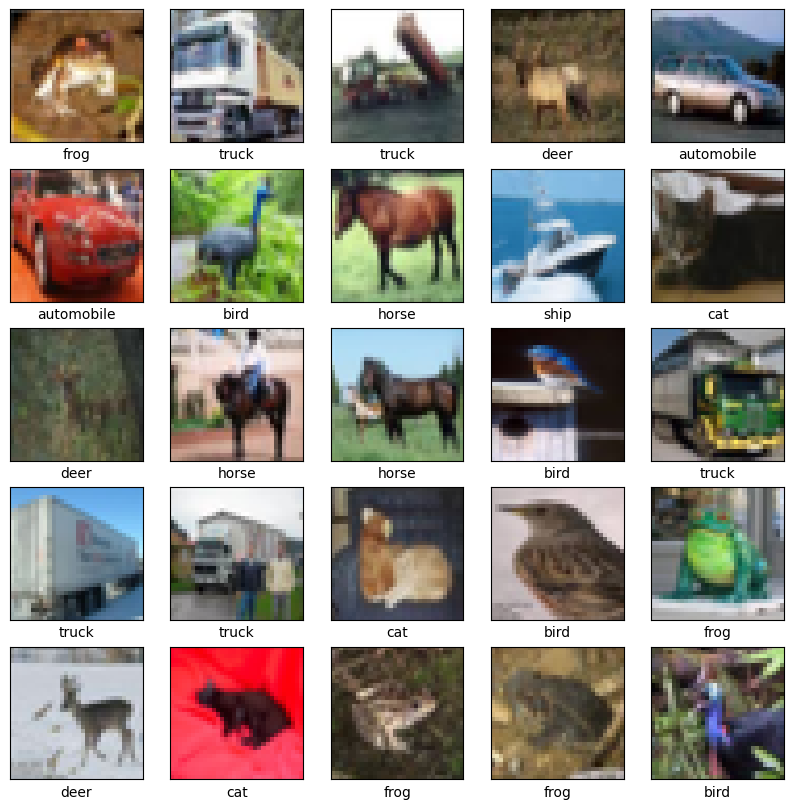

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train_labels[i][0]])
plt.show()

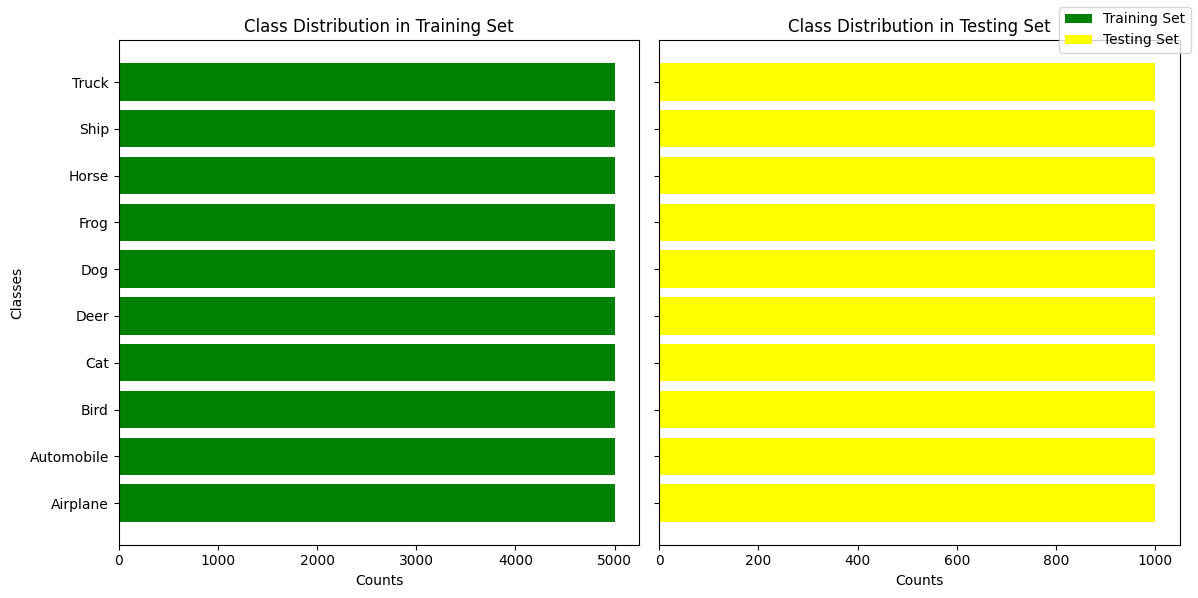

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train and y_test are already defined
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Calculate class distributions for both training and testing sets
train_classes, train_counts = np.unique(y_train_labels, return_counts=True)
test_classes, test_counts = np.unique(y_test_labels, return_counts=True)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].barh(classes_name, train_counts, color='green')
axs[0].set_title('Class Distribution in Training Set')
axs[0].set_xlabel('Counts')
axs[0].set_ylabel('Classes')

# Plot testing set distribution
axs[1].barh(classes_name, test_counts, color='yellow')
axs[1].set_title('Class Distribution in Testing Set')
axs[1].set_xlabel('Counts')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'], loc='upper right')

plt.tight_layout()
plt.show()

Data Augmentation

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
train_datagen.fit(train_images)

# Confirming the shape of the preprocessed data
print(f"Training data shape: {train_images.shape}")


Training data shape: (50000, 32, 32, 3)


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [9]:
#model = models.Sequential()
#First convolutional layers
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

#model.add(layers.MaxPooling2D((3, 3)))
#Second convolutional layers
#model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#model.add(layers.MaxPooling2D((3, 3)))

In [35]:
model = models.Sequential([
    # Single Convolutional Layer
    layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3)),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Flattening the output to feed into a dense layer
    layers.Flatten(),

    # First Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),

    # Output Layer with softmax activation for multi-class classification
    layers.Dense(10, activation='softmax')
])


Let's display the architecture of your model so far:

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)       

In [12]:
!pip install -q visualkeras

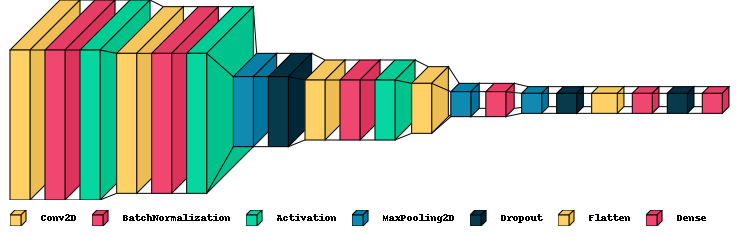

In [37]:
import visualkeras

visualkeras.layered_view(model, spacing=15, legend=True, scale_xy=5, to_file='output.png')

In [38]:
import numpy as np
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display

In [39]:
BATCH_SIZE = 128
EPOCHS = 25

In [40]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)



def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

In [41]:
# lr decay function
def lr_decay(epoch):
  return 0.001 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
#plot_learning_rate(lr_decay, EPOCHS)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,    # Minimum change to qualify as an improvement
    mode='min',         # The training will stop when the quantity monitored stops decreasing
    verbose=1           # Print messages when early stopping is triggered
)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

Optimizations
EPOCHS = Increase epochs to 15.
validation split changed to 0.2
batch_size changed to 32.

In [43]:
model.compile(optimizer='adam',
             # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=EPOCHS,
                    validation_data=(test_images, test_labels),
                   # callbacks=[lr_decay_callback],
                    validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/25
391/391 [==============================] - 10s 18ms/step - loss: 1.6973 - accuracy: 0.3824 - val_loss: 2.6971 - val_accuracy: 0.2164
Epoch 2/25
391/391 [==============================] - 6s 15ms/step - loss: 1.3086 - accuracy: 0.5259 - val_loss: 1.4411 - val_accuracy: 0.5098
Epoch 3/25
391/391 [==============================] - 6s 15ms/step - loss: 1.1507 - accuracy: 0.5899 - val_loss: 1.1288 - val_accuracy: 0.6040
Epoch 4/25
391/391 [==============================] - 7s 17ms/step - loss: 1.0446 - accuracy: 0.6322 - val_loss: 0.9817 - val_accuracy: 0.6498
Epoch 5/25
391/391 [==============================] - 6s 16ms/step - loss: 0.9699 - accuracy: 0.6576 - val_loss: 1.1410 - val_accuracy: 0.6098
Epoch 6/25
391/391 [==============================] - 6s 16ms/step - loss: 0.9169 - accuracy: 0.6755 - val_loss: 0.9691 - val_accuracy: 0.6613
Epoch 7/25
391/391 [==============================] - 6s 16ms/step - loss: 0.8655 - accuracy: 0.6962 - val_loss: 0.8349 - val_accuracy: 0.710

### Evaluate the model

In [44]:
def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], marker='o', label='Train Loss')
  plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model_test):
  test_loss, test_accuracy = model_test.evaluate(test_images, test_labels)
  print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

  plot_convergence()

313/313 [==============================] - 1s 4ms/step - loss: 0.6858 - accuracy: 0.7751
Test Accuracy: 77.51%


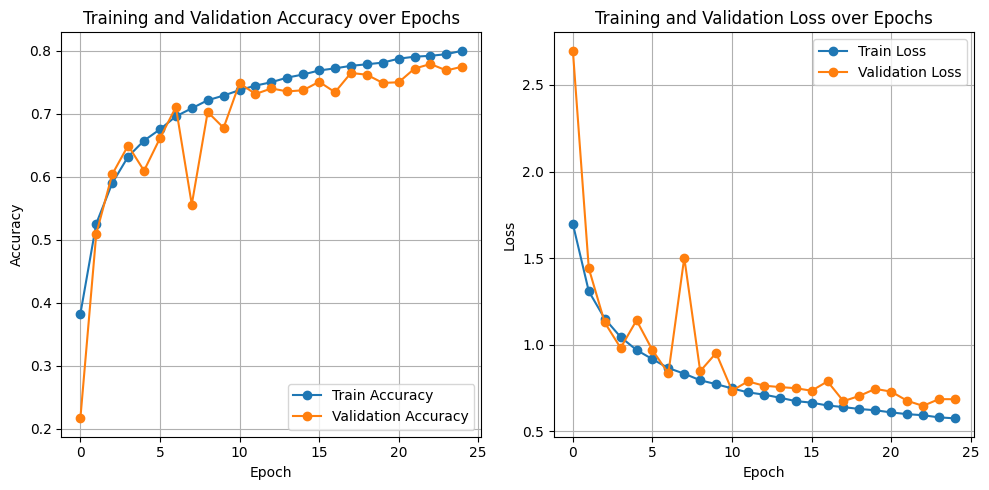

In [45]:
test_model_accuracy(model)

In [46]:
model.save('model_tuned.keras')

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense


model_baseline = Sequential([
    # Single Convolutional Layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),

    # Flattening the output to feed into a dense layer
    Flatten(),

    # Output Layer with softmax activation for multi-class classification
    Dense(10, activation='softmax')
])

model_baseline.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_baseline.summary()

model_baseline.compile(optimizer='adam',
             # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_baseline.fit(train_images, train_labels, epochs=EPOCHS,
                    validation_data=(test_images, test_labels),
                   # callbacks=[lr_decay_callback],
                    validation_split=0.2, batch_size=BATCH_SIZE)


model_baseline.save('model_baseline.keras')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 flatten_4 (Flatten)         (None, 14400)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                144010    
                                                                 
Total params: 144458 (564.29 KB)
Trainable params: 144458 (564.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
391/391 [==============================] - 3s 6ms/step - loss: 1.6381 - accuracy: 0.4288 - val_loss: 1.4478 - val_accuracy: 0.4857
Epoch 2/25
391/391 [==============================] - 2s 4ms/step - loss: 1.3463 - accuracy: 0.5317 - val_loss: 1.3264 - val_accuracy: 0

313/313 [==============================] - 1s 2ms/step - loss: 1.3544 - accuracy: 0.5517
Test Accuracy: 55.17%


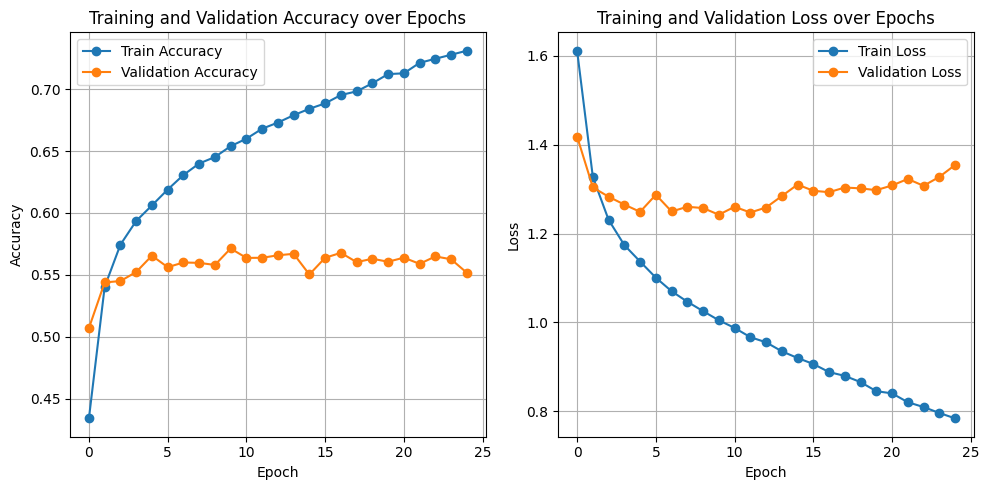

In [33]:
test_model_accuracy(model_baseline)

In [48]:
model_baseline = tf.keras.models.load_model('model_baseline.keras')

# Show the model architecture
model_baseline.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 flatten_4 (Flatten)         (None, 14400)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                144010    
                                                                 
Total params: 144458 (564.29 KB)
Trainable params: 144458 (564.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The simple CNN has achieved a test accuracy of over 70%. validation accuracy of about 60%.